In [1]:
# Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
import gc
import lightgbm as lgb # Using LightGBM

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
BASE_PATH = "./"
RANDOM_STATE = 21
PCA_VARIANCE = 0.95
SUBMISSION_PATH = os.path.join(BASE_PATH, "submission.csv")

# File Names
TRAIN_DATA_FILE = "data/train_data.json"
TEST_DATA_FILE = "data/test_data.json"
METRIC_NAMES_FILE = "data/metric_names.json"
METRIC_EMB_FILE = "data/metric_name_embeddings.npy"
PR_TRAIN_EMB_FILE = "data/pr_train_embeddings.npy"
PR_TEST_EMB_FILE = "data/pr_test_embeddings.npy"

print("Setup Complete. LightGBM imported.")

Setup Complete. LightGBM imported.


In [2]:
# Data Loading

def load_data():
    try:
        train_df = pd.read_json(os.path.join(BASE_PATH, TRAIN_DATA_FILE), lines=True)
        test_df = pd.read_json(os.path.join(BASE_PATH, TEST_DATA_FILE), lines=True)
    except ValueError:
        train_df = pd.read_json(os.path.join(BASE_PATH, TRAIN_DATA_FILE))
        test_df = pd.read_json(os.path.join(BASE_PATH, TEST_DATA_FILE))

    test_df['ID'] = test_df.index

    with open(os.path.join(BASE_PATH, METRIC_NAMES_FILE), encoding='utf-8') as f:
        metric_names = json.load(f)

    metric_embeddings = np.load(os.path.join(BASE_PATH, METRIC_EMB_FILE))
    train_pr_embeddings = np.load(os.path.join(BASE_PATH, PR_TRAIN_EMB_FILE))
    test_pr_embeddings = np.load(os.path.join(BASE_PATH, PR_TEST_EMB_FILE))

    return train_df, test_df, metric_names, metric_embeddings, train_pr_embeddings, test_pr_embeddings

train_df, test_df, metric_names, metric_embeddings, train_pr_emb, test_pr_emb = load_data()
y_train_full = train_df['score'].values

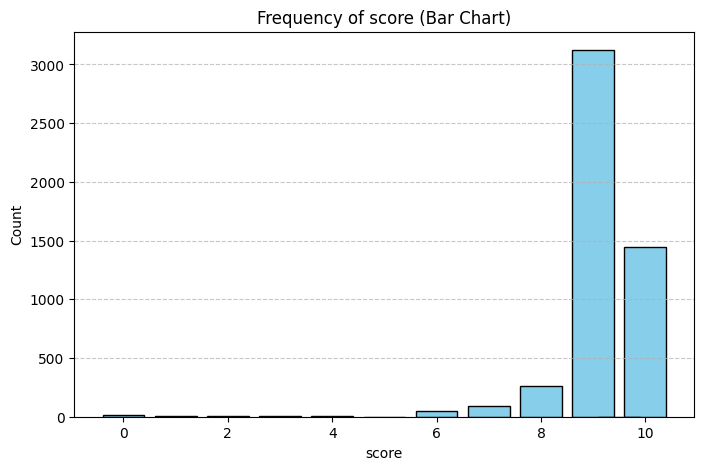

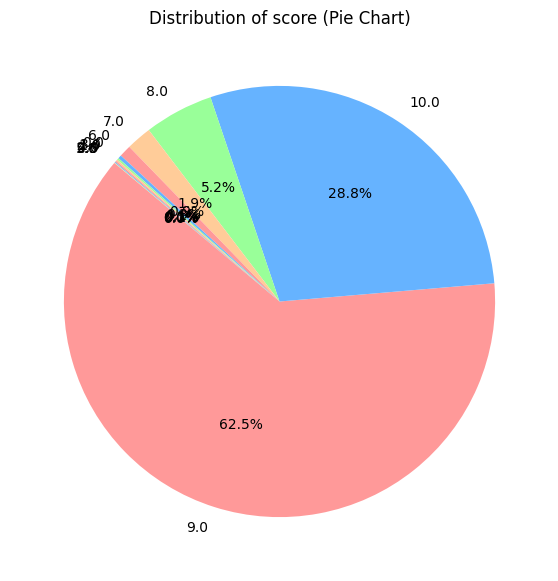

In [3]:
target_column = 'score'
counts = train_df[target_column].value_counts()

# ---------------------------------------------------------
# PLOT 1: Bar Chart
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))  # Set figure size
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

plt.title(f'Frequency of {target_column} (Bar Chart)')
plt.xlabel(target_column)
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------------------------------------------------
# PLOT 2: Pie Chart
# ---------------------------------------------------------

plt.figure(figsize=(7, 7))
plt.pie(counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

plt.title(f'Distribution of {target_column} (Pie Chart)')
plt.show()

In [13]:
# Feature Engineering

def engineer_features(train_df, test_df, metric_names, metric_embeddings, train_pr_emb, test_pr_emb):
    print("--- 2. Feature Engineering ---")

    metric_name_to_index = {name: i for i, name in enumerate(metric_names)}

    train_m_indices = [metric_name_to_index[name] for name in train_df['metric_name']]
    test_m_indices = [metric_name_to_index[name] for name in test_df['metric_name']]

    train_m_emb = metric_embeddings[train_m_indices]
    test_m_emb = metric_embeddings[test_m_indices]

    # Interaction Helper
    def get_interactions(u, v):
        diff = np.abs(u - v)
        prod = u * v
        return np.hstack([u, v, diff, prod])

    print("   Generating vectors...")
    X_train_inter = get_interactions(train_m_emb, train_pr_emb)
    X_test_inter = get_interactions(test_m_emb, test_pr_emb)

    print("   Calculating distances...")
    cos_train = paired_cosine_distances(train_m_emb, train_pr_emb).reshape(-1, 1)
    cos_test = paired_cosine_distances(test_m_emb, test_pr_emb).reshape(-1, 1)

    l2_train = np.linalg.norm(train_m_emb - train_pr_emb, axis=1).reshape(-1, 1)
    l2_test = np.linalg.norm(test_m_emb - test_pr_emb, axis=1).reshape(-1, 1)

    X_train = np.hstack([X_train_inter, cos_train, l2_train])
    X_test = np.hstack([X_test_inter, cos_test, l2_test])

    return X_train, X_test

X_train_raw, X_test_raw = engineer_features(
    train_df, test_df, metric_names, metric_embeddings, train_pr_emb, test_pr_emb
)
del metric_embeddings, train_pr_emb, test_pr_emb
gc.collect()

--- 2. Feature Engineering ---
   Generating vectors...
   Calculating distances...


7122

In [14]:
# Cell 4: Preprocessing (PCA)

def preprocess_and_pca(X_train, X_test):
    print("--- 3. Scaling and PCA ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"   Fitting PCA ({PCA_VARIANCE*100}% variance)...")
    pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"   Final Dim: {X_train_pca.shape[1]}")
    return X_train_pca, X_test_pca

X_train_pca, X_test_pca = preprocess_and_pca(X_train_raw, X_test_raw)
del X_train_raw, X_test_raw
gc.collect()

--- 3. Scaling and PCA ---
   Fitting PCA (95.0% variance)...
   Final Dim: 988


0

In [15]:
# Cell 5a: Train Isolation Forest Gatekeeper

from sklearn.ensemble import IsolationForest

print("\n--- 4a. Training Isolation Forest Gatekeeper ---")

# --- A. Prepare Normal Data (High Scores > 7) ---
# NOTE: These lines were missing and caused the NameError.
# Assuming X_train_pca and y_train_full are loaded from prior steps.
mask_high = (y_train_full > 7)
X_high = X_train_pca[mask_high]
y_high = y_train_full[mask_high]

print(f"   Training Isolation Forest on {len(y_high)} 'Normal' samples (Scores 9-10)...")

# Define and train the Isolation Forest model
gating_model = IsolationForest(
    n_estimators=500,
    max_samples='auto',
    contamination=0.21,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# Fit ONLY on 9s and 10s
gating_model.fit(X_high)

print("   Isolation Forest Gatekeeper Trained.")


--- 4a. Training Isolation Forest Gatekeeper ---
   Training Isolation Forest on 4825 'Normal' samples (Scores 9-10)...
   Isolation Forest Gatekeeper Trained.


In [16]:
# Train Low Score Expert (LSE) (Target <= 7) WITH SAMPLE WEIGHTS

import lightgbm as lgb
import numpy as np
import pandas as pd # Import pandas needed for value_counts and mapping

print("\n--- 4b. Training Low Score Expert (LSE) (WITH SAMPLE WEIGHTS) ---")

# --- Define LSE Parameters ---
# Define LGBM_COMMON_PARAMS here to ensure the cell is independent
LGBM_COMMON_PARAMS = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'verbosity': -1
}

LGBM_LSE_PARAMS = LGBM_COMMON_PARAMS.copy()
LGBM_LSE_PARAMS.update({
    'objective': 'mae',
    'metric': 'mae',
    'max_depth': 5,
    'num_leaves': 15,
    'min_child_samples': 10
})

mask_low = (y_train_full <= 7)
X_low = X_train_pca[mask_low]
y_low = y_train_full[mask_low]

# --- CALCULATE SAMPLE WEIGHTS ---
# 1. Convert y_low to a pandas Series for easy counting
y_low_series = pd.Series(y_low)

# 2. Get the frequency of each unique score
score_counts = y_low_series.value_counts()

# 3. Calculate the inverse frequency (Weight = 1 / Count).
inverse_frequencies = 1 / score_counts

# 4. Map the weights back to the original samples in y_low
lse_sample_weights = y_low_series.map(inverse_frequencies).values

print(f"   Training LSE on {len(y_low)} 'Anomaly' samples (Scores 0-8) with weights...")

# Define and train the LSE model
lse_model = lgb.LGBMRegressor(**LGBM_LSE_PARAMS)

# --- APPLY THE WEIGHTS ---
lse_model.fit(X_low, y_low, sample_weight=lse_sample_weights)

print("   Low Score Expert Trained with Sample Weights.")


--- 4b. Training Low Score Expert (LSE) (WITH SAMPLE WEIGHTS) ---
   Training LSE on 175 'Anomaly' samples (Scores 0-8) with weights...
   Low Score Expert Trained with Sample Weights.


In [17]:
# Cell 5c: Train High Score Expert (HSE) (Target > 7) WITH SAMPLE WEIGHTS

print("\n--- Training High Score Expert (HSE) (WITH SAMPLE WEIGHTS) ---")

# --- Define HSE Parameters ---
# Define LGBM_COMMON_PARAMS here to ensure the cell is independent
LGBM_COMMON_PARAMS = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'verbosity': -1
}

LGBM_LSE_PARAMS = LGBM_COMMON_PARAMS.copy()
LGBM_LSE_PARAMS.update({
    'objective': 'rmse',
    'metric': 'rmse',
    'max_depth': 5,
    'num_leaves': 15,
    'min_child_samples': 10
})

# Assuming y_train_full and X_train_pca are available globally.
mask_low = (y_train_full > 7)
X_low = X_train_pca[mask_low]
y_low = y_train_full[mask_low]

# --- CALCULATE SAMPLE WEIGHTS ---
# 1. Convert y_low to a pandas Series for easy counting
y_low_series = pd.Series(y_low)

# 2. Get the frequency of each unique score
score_counts = y_low_series.value_counts()

# 3. Calculate the inverse frequency (Weight = 1 / Count).
inverse_frequencies = 1 / score_counts

# 4. Map the weights back to the original samples in y_low
hse_sample_weights = y_low_series.map(inverse_frequencies).values

print(f"   Training LSE on {len(y_low)} 'Anomaly' samples (Scores 0-8) with weights...")

# Define and train the HSE model
hse_model = lgb.LGBMRegressor(**LGBM_LSE_PARAMS)

# --- APPLY THE WEIGHTS ---
hse_model.fit(X_low, y_low, sample_weight=hse_sample_weights)

print("   High Score Expert Trained with Sample Weights.")


--- Training High Score Expert (HSE) (WITH SAMPLE WEIGHTS) ---
   Training LSE on 4825 'Anomaly' samples (Scores 0-8) with weights...
   High Score Expert Trained with Sample Weights.


In [41]:
# Gating and Prediction

def generate_simplified_predictions(gate, lse, hse, X_test, threshold=0.0):
    print("\n--- 5. Generating Simplified Predictions ---")

    # 1. Get Anomaly Scores
    # < threshold = Anomaly (Route to LSE)
    # > threshold = Normal (Route to HSE)
    anomaly_scores = gate.decision_function(X_test)

    # 2. Routing Logic
    idx_lse = np.where(anomaly_scores <= threshold)[0] # Anomaly
    idx_hse = np.where(anomaly_scores > threshold)[0]  # Normal

    final_preds = np.zeros(X_test.shape[0])

    # 3. Predict Low Scores
    if len(idx_lse) > 0:
        print(f"   Routing {len(idx_lse)} samples to LSE (Score <= {threshold})")
        preds_low = lse.predict(X_test[idx_lse])
        final_preds[idx_lse] = preds_low

    # 4. Predict High Scores
    if len(idx_hse) > 0:
        print(f"   Routing {len(idx_hse)} samples to HSE")
        preds_high = hse.predict(X_test[idx_hse])
        final_preds[idx_hse] = preds_high

    # 5. Clip to valid range
    final_preds = np.clip(final_preds, 0, 10)

    # Stats
    print(f"   Prediction Stats -> Min: {final_preds.min():.2f}, Mean: {final_preds.mean():.2f}, Max: {final_preds.max():.2f}")

    return final_preds

# --- Run Prediction ---
# Start threshold at 0.0. Increase to 0.02 or 0.05 to force more samples into LSE.
ANOMALY_THRESHOLD = 0.021

final_scores = generate_simplified_predictions(gating_model, lse_model, hse_model, X_test_pca, threshold=ANOMALY_THRESHOLD)
final_scores = np.round(final_scores, 0)



--- 5. Generating Simplified Predictions ---
   Routing 2955 samples to LSE (Score <= 0.021)
   Routing 683 samples to HSE
   Prediction Stats -> Min: 2.00, Mean: 6.01, Max: 10.00


In [42]:
# --- Submission ---
submission = pd.DataFrame({
    'ID': test_df['ID']+1,
    'score': final_scores
})
submission.to_csv("somethingworked.csv", index=False)
print(f"\nSubmission saved to: {SUBMISSION_PATH}")


Submission saved to: ./submission.csv
